# Banka Kredi Onayı Tahmin Modeli

Gerekli kütüphanler:

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt

2000 adet sentetik müşteri kaydından oluşan bir veri seti oluşturalım.

In [2]:
np.random.seed(42)

numOfSamples = 2000

age = np.random.randint(18, 65, numOfSamples)
income = np.random.randint(3000, 30000, numOfSamples)
debt = np.random.randint(0, 50000, numOfSamples)
credit_score = np.random.randint(0, 1000, numOfSamples)
employment_years = np.random.randint(0, 40, numOfSamples)
approved = (
    (income > 8000) &
    (debt < 20000) &
    (credit_score > 300) &
    (employment_years >= 2) &
    (age >= 21)
).astype(int)

# Gürültü ekleme
income += np.random.normal(0, 3000, income.shape).astype(int)
debt += np.random.normal(0, 4000, debt.shape).astype(int)
credit_score += np.random.normal(0, 50, credit_score.shape).astype(int)

# Negatifleri temizle
income = np.clip(income, 0, None)
debt = np.clip(debt, 0, None)
credit_score = np.clip(credit_score, 0, 1000)

Approved değişkeni, bir kişinin kredi başvurusunun onaylanıp onaylanmadığını belirler. Kredi başvurusu onaylanmak için başvuru sahibinin geliri 8000'den yüksek, borcu 20000'den düşük, kredi puanı 300'ün üzerinde, çalışma süresi en az 2 yıl ve yaşı 21 veya daha büyük olmalıdır. Bu şartlar sağlandığında approved değeri 1 (onaylandı), aksi takdirde 0 (reddedildi) olarak atanır. Her bir başvuru için bu kurallar uygulanarak approved listesi oluşturulur.

In [3]:
df = pd.DataFrame({
    "age": age,
    "income": income,
    "debt": debt,
    "credit_score": credit_score,
    "employment_years": employment_years,
    "approved": approved
})

In [4]:
df

,age,income,debt,credit_score,employment_years,approved
0,56,6065,13378,173,36,0
1,46,27128,38983,452,17,0
2,32,29368,9823,156,16,0
3,60,7113,48193,642,8,0
4,25,27817,46907,395,13,0
...,...,...,...,...,...,...
1995,42,23552,24221,797,6,1
1996,37,5874,26197,215,16,0
1997,19,16415,19635,645,28,0
1998,56,8533,25907,495,29,0


1 -> Onaylandı

0 -> Reddedildi

In [5]:
df['approved'].value_counts()

approved
0    1611
1     389
Name: count, dtype: int64

**Histogram (Gelir Dağılımı)**

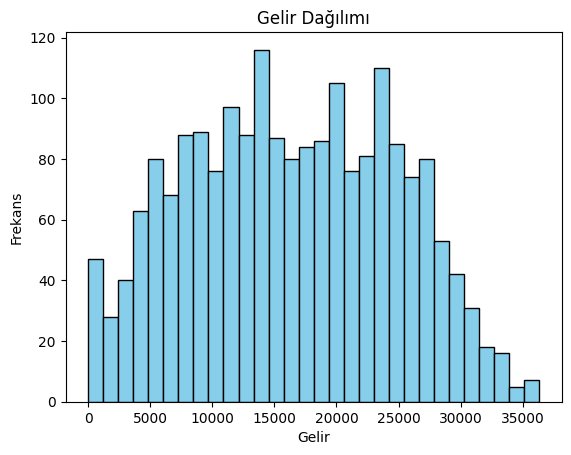

In [6]:
plt.hist(df['income'], bins=30, color='skyblue', edgecolor='black')
plt.title('Gelir Dağılımı')
plt.xlabel('Gelir')
plt.ylabel('Frekans')
plt.show()

Grafikte gelirlerin çoğunlukla 5.000 TL ile 25.000 TL arasında yoğunlaştığı görülüyor. En yüksek frekans 15.000 TL civarında. Gelir dağılımı sağa çarpık (right-skewed), yani yüksek gelirli bireyler azınlıkta. Bu durum, gerçek hayattaki gelir eşitsizliğini yansıtır nitelikte.

**Boxplot (Kredi Puanı ve Onay Durumu)**

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9692\1306633741.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='approved', y='credit_score', data=df, palette="Set2")


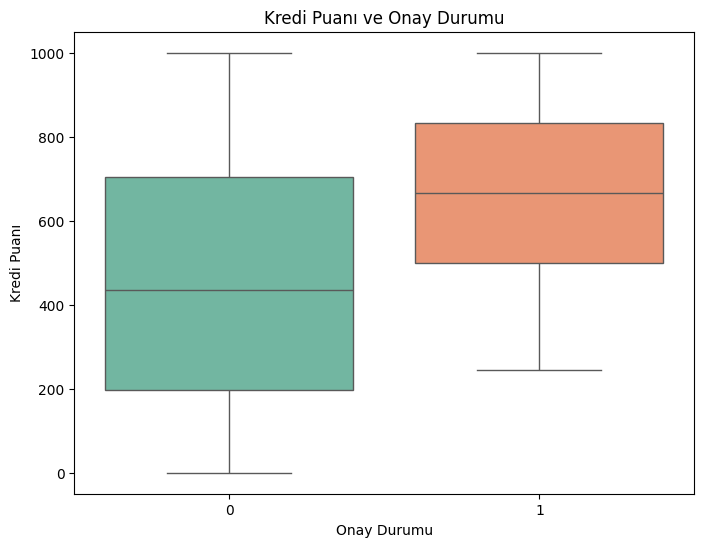

In [7]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x='approved', y='credit_score', data=df, palette="Set2")
plt.title('Kredi Puanı ve Onay Durumu')
plt.xlabel('Onay Durumu')
plt.ylabel('Kredi Puanı')
plt.show()

Bu grafik, kredi puanı yüksek olan kişilerin başvurularının daha çok onaylandığını göstermektedir. Onaylanan başvuruların medyan kredi puanı, reddedilenlerden belirgin şekilde daha yüksektir. Bu da kredi puanının onay kararında önemli bir rol oynadığını ortaya koymaktadır.

**Pairplot (Seaborn Pairplot)**

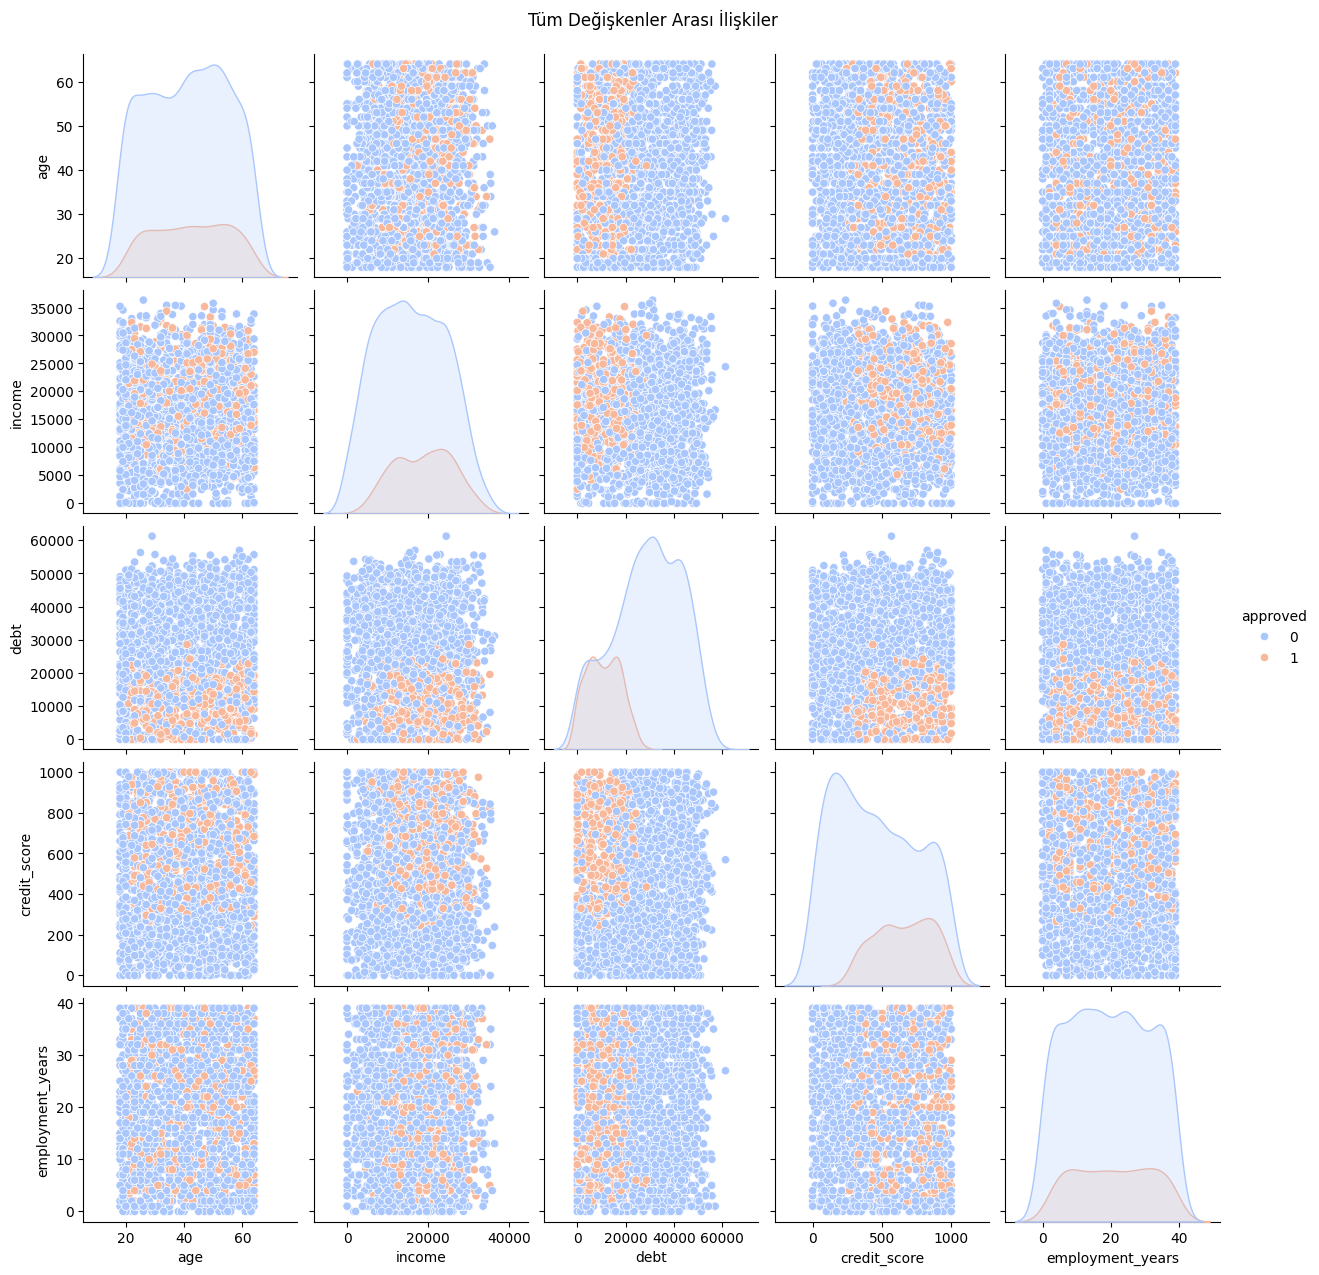

In [8]:
sns.pairplot(df, hue="approved", palette="coolwarm")
plt.suptitle("Tüm Değişkenler Arası İlişkiler", y=1.02)
plt.show()

Grafik, gelir, kredi puanı ve istihdam yılı arttıkça onay alma olasılığının yükseldiğini; borç arttıkça ise onay olasılığının azaldığını gösteriyor. Onaylanan bireyler genelde daha iyi finansal göstergelere sahip.

Verimizi ve Dağılımları İnceledik. Şimdi Modelimizi Eğitelim.

In [9]:
X = df[['age', 'income', 'debt', 'credit_score', 'employment_years']]
y = df['approved']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)
y_prediction = model.predict(X_test)

**Accuracy**

In [11]:
print("Accuracy:", accuracy_score(y_test, y_prediction))

Accuracy: 0.9375


 Modelinin doğruluk oranı %93.75, yani test verisinin büyük kısmını doğru tahmin etmiş. Bu, modelin genelde başarılı çalıştığını gösteriyor.

 Doğruluk (Accuracy): (TP + TN) / Toplam = (64 + 311) / (64 + 311 + 10 + 15) = 375 / 400 = 0,9375 veya %93,75

**Confusion Matrix**

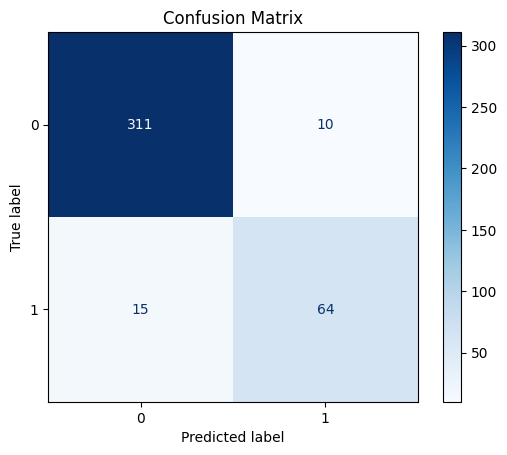

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix hesapla
cm = confusion_matrix(y_test, y_prediction)

# Görselleştir
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Classification Report

**Precision**

In [13]:
print("Precision:", precision_score(y_test, y_prediction))

Precision: 0.8648648648648649


Kesinlik (Precision): TP / (TP + FP) = 64 / (64 + 10) = 64 / 74 = 0,865 veya %86,5

**Recall**

In [14]:
print("Recall:", recall_score(y_test, y_prediction))

Recall: 0.810126582278481


Duyarlılık (Recall): TP / (TP + FN) = 64 / (64 + 15) = 64 / 79 = 0,810 veya %81,0

**F1 Score**

In [15]:
f1 = f1_score(y_test, y_prediction)
print(f"F1 Score: {f1}")

F1 Score: 0.8366013071895425


F1 Skoru: 2 × (Kesinlik × Duyarlılık) / (Kesinlik + Duyarlılık) = 2 × (0,865 × 0,810) / (0,865 + 0,810) = 0,836 veya %83,6

Bu kredi onayı tahmin modelinin sonuçlarına göre, model %93,75 genel doğrulukla oldukça başarılı çalışıyor. Özellikle kredi verilmemesi gereken müşterileri %96,9 başarıyla tespit ederek bankayı finansal risklerden koruyor. Ancak, kredi almayı hak eden müşterilerin %19'unu haksız yere reddetme eğiliminde, bu da potansiyel gelir kaybına neden olabilir. Model bankaya güçlü bir risk yönetimi aracı sunuyor fakat değerli müşterileri kaçırmamak için duyarlılık oranının iyileştirilmesi faydalı olacaktır.